<a href="https://colab.research.google.com/github/rashmi0888/Deep-Learning/blob/master/GAN/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network for MNIST Dataset
### Import relevant components

In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.layers import Input, Dropout
from keras.models import Model, Sequential
from keras.layers.core import Dense
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
np.random.seed(100)

### Data Preparation

In [ ]:
# Data Dimensions
training_samples = 60000
input_dim = 784
noise_dim = 100
epochs = 100


# Download, Reshape and Normalize Data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(training_samples, input_dim)
X_train = X_train.astype('float32')
X_train /= 255


# Optimiser
adam = Adam(lr=0.0002, beta_1=0.5)

### Build GAN

In [ ]:
# Create Generator
generator = Sequential()
generator.add(Dense(256, activation=LeakyReLU(alpha=0.2), input_shape=(noise_dim,)))
generator.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
generator.add(Dense(1024, activation=LeakyReLU(alpha=0.2)))
generator.add(Dense(input_dim, activation='sigmoid'))
generator.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])


# Create Discriminator
discriminator = Sequential()
discriminator.add(Dense(1024, activation=LeakyReLU(alpha=0.2), input_shape=(input_dim,)))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])


# Create GAN by combining generator and discriminator
discriminator.trainable = False
input = Input(shape=(noise_dim,))
hidden = generator(input)
output = discriminator(hidden)
gan = Model(input, output)
gan.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])


# Plot loss and accuracy
def plot_losses(losses, learning_rate, batch_size):
    discriminator_loss = [v[0] for v in losses["D"]]
    generator_loss = [v[0] for v in losses["G"]]
    discriminator_accuracy = [v[1] for v in losses["D"]]
    generator_accuracy = [v[1] for v in losses["G"]]

    plt.figure(figsize=(10, 8))
    plt.plot(discriminator_loss, label="Discriminator loss")
    plt.plot(generator_loss, label="Generator loss")
    plt.title("LR:{}, BS:{},".format(learning_rate, batch_size), pad=-20)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 8))
    plt.plot(discriminator_accuracy, label="Discriminator accuracy")
    plt.plot(generator_accuracy, label="Generator accuracy")
    plt.title("LR:{}, BS:{},".format(learning_rate, batch_size), pad=-20)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.legend()
    plt.show()


# Plot generated images
def plot_generated_images(epoch, examples=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(examples, noise_dim))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt. show()

# Train GAN
def train(learning_rate = 0.0002, batch_size = 128, plot_freq=10):
    batch_count = int(X_train.shape[0] /batch_size)
    losses = {"D": [], "G": []}
    for e in range(1, epochs + 1):
        #print('-' * 15, 'Epoch %d' % e, '-' * 15)
        d_loss = None
        g_loss = None
        for _ in range(batch_count):
            # Get a random set of real images from training set
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

            # Generate random noise as input to initialize generator
            noise = np.random.normal(0, 1, size=(batch_size, noise_dim))

            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)

            # Create different batches of real and fake images
            X = np.concatenate((image_batch, generated_images))

            # Labels for real and fake images
            y = np.zeros(2 * batch_size)
            y[:batch_size] = 0.9  # One-sided label smoothing

            # Pre-train discriminator on real and fake images before starting GAN
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y)

            # Trick noised input of generator as real images
            noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
            y2 = np.ones(batch_size)

            # During training of GAN, weights of discriminator should be fixed.
            # We can enforce that by setting trainable flag
            discriminator.trainable = False

            #Train GAN
            g_loss = gan.train_on_batch(noise, y2)

        # Store loss from final batch of this epoch
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Plot generated images for selected epochs
        if e == 1 or e==epochs or e % plot_freq == 0:
            print('-' * 15, 'Epoch %d' % e, '-' * 15)
            plot_generated_images(e)

    # Plot losses
    plot_losses(losses, learning_rate, batch_size)

/usr/local/lib/python3.6/dist-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


--------------- Epoch 1 ---------------


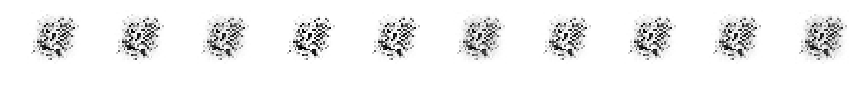

--------------- Epoch 10 ---------------


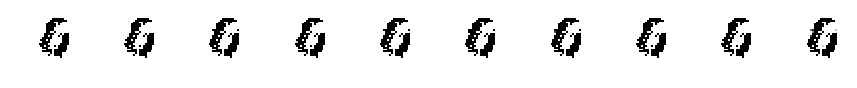

--------------- Epoch 20 ---------------


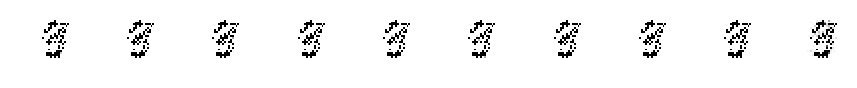

--------------- Epoch 30 ---------------


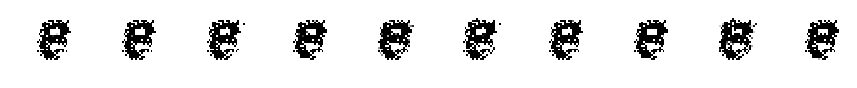

--------------- Epoch 40 ---------------


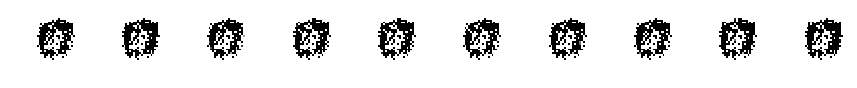

--------------- Epoch 50 ---------------


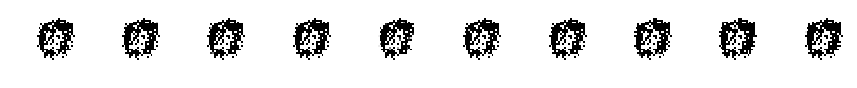

--------------- Epoch 60 ---------------


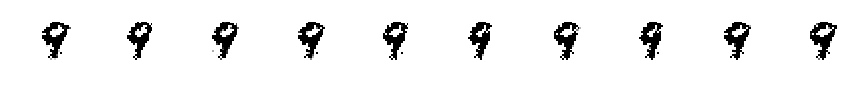

--------------- Epoch 70 ---------------


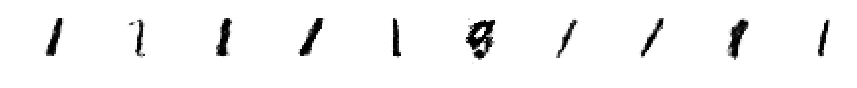

--------------- Epoch 80 ---------------


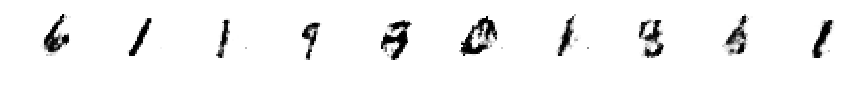

--------------- Epoch 90 ---------------


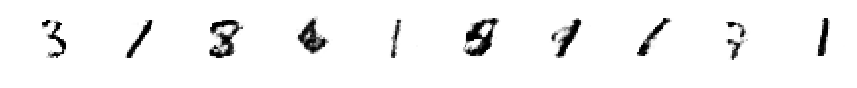

--------------- Epoch 100 ---------------


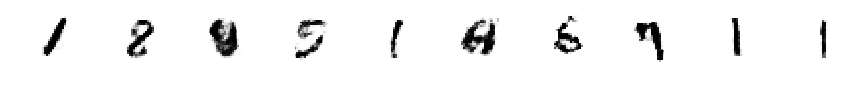

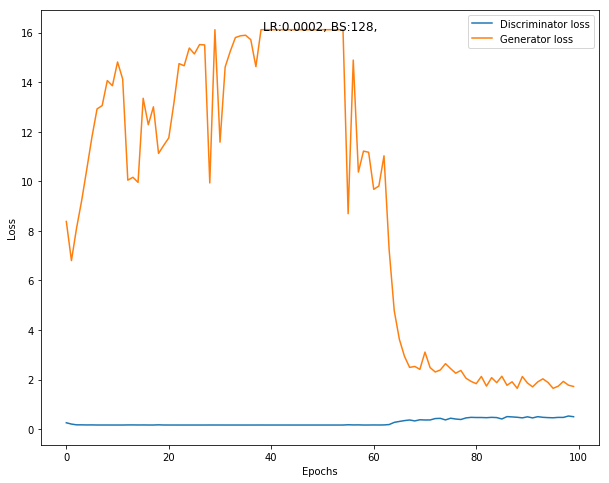

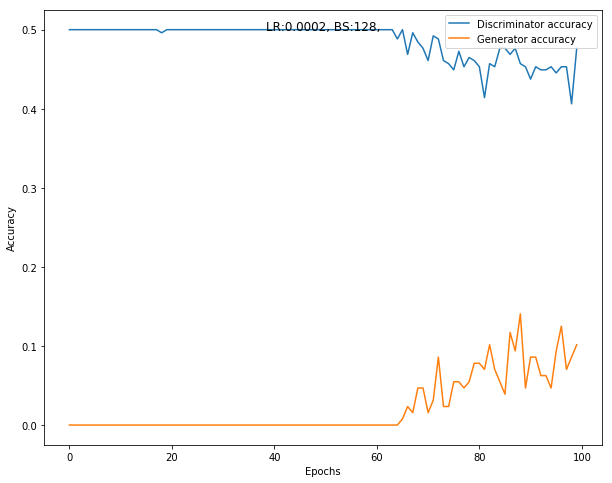

In [ ]:
train(learning_rate = 0.0002, batch_size = 128, plot_freq = 10)

### Influence of learning rate and batch size on performance

--------------- Epoch 1 ---------------


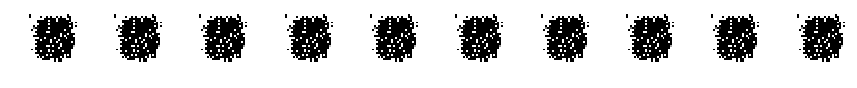

--------------- Epoch 10 ---------------


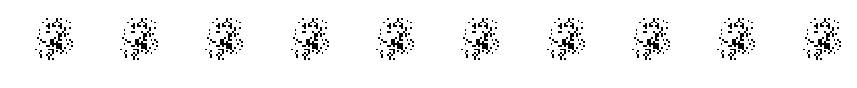

--------------- Epoch 20 ---------------


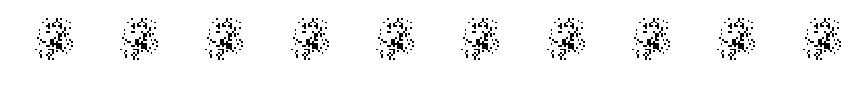

--------------- Epoch 30 ---------------


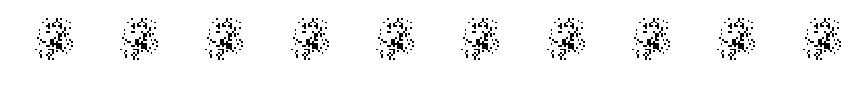

--------------- Epoch 40 ---------------


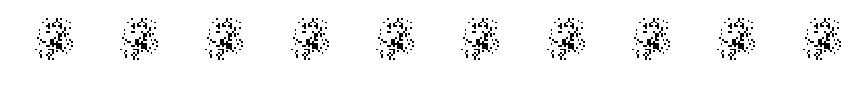

--------------- Epoch 50 ---------------


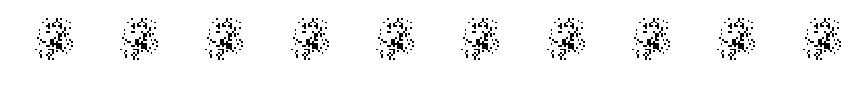

--------------- Epoch 60 ---------------


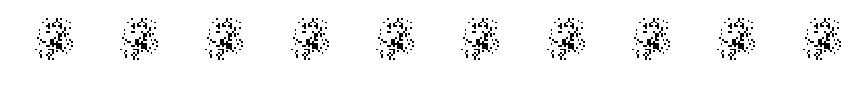

--------------- Epoch 70 ---------------


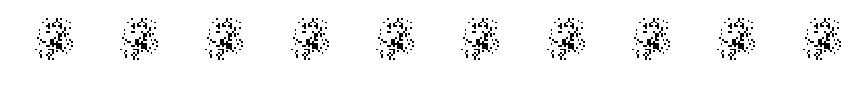

--------------- Epoch 80 ---------------


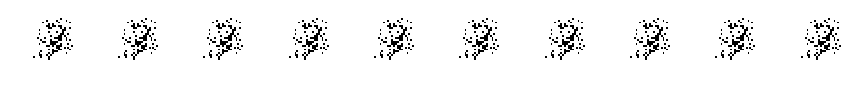

--------------- Epoch 90 ---------------


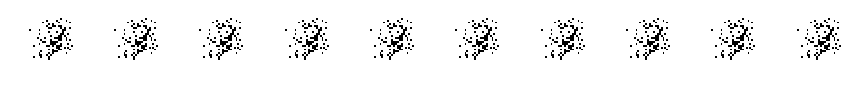

--------------- Epoch 100 ---------------


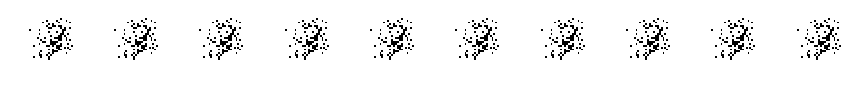

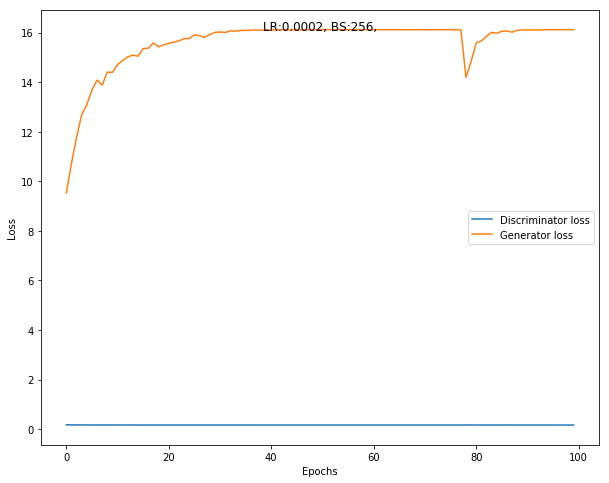

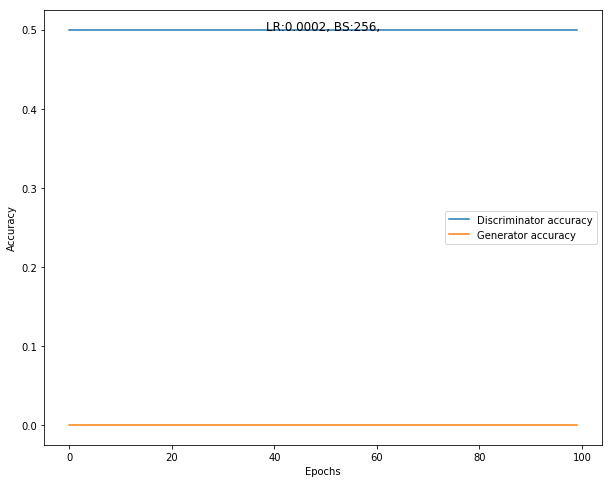

In [ ]:
train(learning_rate = 0.0002, batch_size = 256, plot_freq = 10)